# Code to calulate saturation of a Strain Controlled Chaboche Model

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import math

In [2]:
def extract_min_max(data, cycle_number, start_max = True ):
    '''
    Extracts minimum or maximum from given file depending on the cycle and if first half-cycle is compressive or tensile.
    
    Inputs
    --------
    data: np.array
    cycle_number: integer
    start_max: Boolean
        True if the simulation starts with straining, False if it starts with compression
   
        
    Outputs
    --------
    _: float
    minimum or maximum value of the given data    
    '''
    if start_max:
        if cycle_number%2 == 0:
            return np.max(data)
        else: 
            return np.min(data)
    else:
        if cycle_number%2 == 0:
            return np.min(data)
        else: 
            return np.max(data)

In [3]:
def estimate_saturation(plastic_strain_5th_cycle, b_value):
    '''
    Estimates the saturation using the 5th cycle of the simulation.
    
    Inputs
    --------
    plastic_strain_5th_cycle: list
        list of the maximal and minimal value of the plastic strain in the 5th cycle 
    b_value: float
        isotropic hardening exponent
          
    Outputsa
    --------
    _: int
    estimated cycle until saturation
    '''
    return int(5/((-plastic_strain_5th_cycle[0]+plastic_strain_5th_cycle[1])*2*b_value))

In [4]:
def plot_stress(name, data):
    '''
    Plots stress by extracting maximum and minimim from provided data
    
    Inputs
    --------
    name: string
        Name of the sample
    data: list, np.array, pd.DataFrame
        stress_values
          
    Outputs
    --------
    Plot of minimum and maximum value
    '''
    plt.title(name)
    plt.plot(np.array(data[::2]))
    plt.plot(np.array(data[1::2]))
    plt.show()

In [5]:
def calculate_saturation_curve(data, threshold = False, stress_range = True):
    '''
    Calculates the saturation curve
    
    Inputs
    --------
    data: list, np.array, pd.DataFrame
        stress data
    threshold: integer
        threshold until which the data will be evaluated        
    stress_range: Boolean
        True if minimum and maximum amplitude in data, False if only one part of the Amplitudes (min or max)
          
    Outputs
    --------
    _: np.array
        saturation curve, assuming the last given value is a saturated value                
    '''
    if threshold:
        data = data[: threshold]

    if stress_range:
        odd_values = data[::2]
        even_values = data[1::2]
        
        if len(odd_values) == len(even_values):
            c = np.abs(odd_values) + np.abs(even_values)
            
        else:
            c = np.abs(odd_values[:-1]) + np.abs(even_values)
    else:
        c = data
        
    return (c-c[0])/(c[-1]-c[0])

In [6]:
def find_saturation(data, cut=0.95, stress_range = True):
    '''
    Finds the stress saturation
    
    Inputs
    --------
    data: array
        stress data
    cut: float 
        value between 0 and 1 that defines the % of change that is still allowed at the onset of saturation
        Standard 0.95 defined for two standard deviations.
    stress_range: Boolean
        True if minimum and maximum amplitude in data, False if only one part of the Amplitudes (min or max)
    
    Outputs
    --------
    saturation_values: np.array
        returns the saturation cycle by calculating it for every possible saturation point.
    '''
    saturation_values = []
    i = 5
    
    if stress_range:
        limit =  int(len(data)/2-2)
    else:
        limit = len(data)-2
        
    while i < limit:
        saturation_curve = calculate_saturation_curve(data, threshold = i, stress_range = stress_range)
        saturation_values.append(calculate_saturation_value(saturation_curve, cut = cut))
        i += 1
    return np.array(saturation_values)

In [7]:
def calculate_saturation_value(saturation_curve, cut=0.95):
    '''
    Calculates the Point of saturation according to the given cut
    
    Inputs
    --------
    saturation_curve: array
        stress data
    cut: float 
        value between 0 and 1 that defines the % of change that is still allowed at the onset of saturation
        Standard 0.95 defined for two standard deviations.
       
    Outputs
    --------
    _: integer
        returns the estimated cycle for which the cut is reached for the first time.
    '''
    df=pd.DataFrame(saturation_curve, columns=["value"])
    return int(df.value[df.value>cut].first_valid_index())

In [8]:
def saturation_cycle(saturation_values):
    '''
    Checks if saturation occurs and if it is stable for at least 15 half-cycles
    
    Inputs
    --------
    saturation_values: array
        Saturation Curve
          
    Outputs
    --------
    _: integer
        returns the estimated cycle that is stable in the given data
    
    '''
    if np.count_nonzero(np.gradient(saturation_values)[1:] == 0) > 15:
        return int(saturation_values[-1])
    else:
        return np.nan

In [9]:
PATH=os.getcwd()
FILE_NAME = 'stress_data'

plastic_strain_5th_cycle = np.array([-0.00684177,  0.00673622])



In [10]:
stress_data = np.array(pd.read_csv(f"{PATH}/example_data/{FILE_NAME}.csv").stress)
current_results["saturation_estimate"] = estimate_saturation(plastic_strain_5th_cycle, 3.5)

saturation_values = find_saturation(stress_data, cut=0.95)
saturation_values_top = find_saturation(stress_data[::2], cut=0.95, stress_range = False)
saturation_values_bottom = find_saturation(stress_data[1::2], cut=0.95, stress_range = False)

current_results["saturation_cycle_calculated"] = saturation_cycle(saturation_values)
current_results["max_amp_saturation_cycle_calculated"] = saturation_cycle(saturation_values_top)
current_results["min_amp_saturation_cycle_calculated"] = saturation_cycle(saturation_values_bottom)

result_dict[FILE_NAME] = current_results

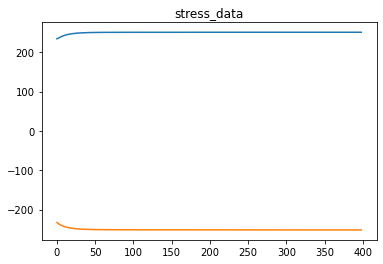

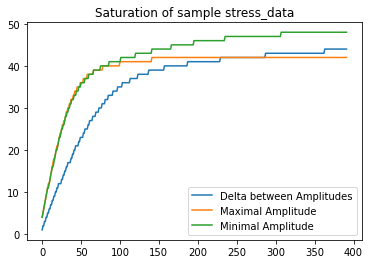

In [11]:
plot_stress(FILE_NAME, stress_data)
plt.plot()

plt.title(f"Saturation of sample {FILE_NAME}")
plt.plot(saturation_values, label= "Delta between Amplitudes")
plt.plot(saturation_values_top, label = "Maximal Amplitude")
plt.plot(saturation_values_bottom, label = "Minimal Amplitude")
plt.legend()
plt.show()


In [12]:
pd.DataFrame(result_dict).T

,max_amp_saturation_cycle_calculated,min_amp_saturation_cycle_calculated,saturation_cycle_calculated,saturation_estimate
stress_data,42,48,44,52
